<a href="https://colab.research.google.com/github/xuwenxinedu/Principles-of-AI/blob/main/Tianchi_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
from google.colab import drive

drive.mount('/gdrive')

%cd /gdrive/My Drive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive


In [2]:
%cd /gdrive/My Drive
%cd COLAB

/gdrive/My Drive
/gdrive/My Drive/COLAB


In [3]:
!ls

hy_round1_train_20200102  npy	    Tianchi_CNN.ipynb
new.ipynb		  RF.ipynb  train.feather


In [4]:
import numpy as np
import pandas as pd
import sklearn.metrics as mtr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import Callback, EarlyStopping
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Reshape, Dropout, merge, Add
from keras.layers.embeddings import Embedding
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
import warnings
import random as rn
import tensorflow as tf
from keras.models import load_model
import os
from sklearn.metrics import f1_score
from collections import Counter
import keras
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [5]:
train = 'train.feather'

In [6]:
train = pd.read_feather(train)

In [7]:
train[train.isna().T.any()]

,渔船ID,x,y,速度,方向,time,type


In [9]:

train.columns = ['id', 'x', 'y', 'speed', 'ori', 'time', 'type']
train.head()

,id,x,y,speed,ori,time,type
0,0,6.152038e+06,5.124873e+06,2.59,102,1110 11:58:19,拖网
1,0,6.151230e+06,5.125218e+06,2.70,113,1110 11:48:19,拖网
2,0,6.150421e+06,5.125563e+06,2.70,116,1110 11:38:19,拖网
3,0,6.149612e+06,5.125907e+06,3.29,95,1110 11:28:19,拖网
4,0,6.148803e+06,5.126252e+06,3.18,108,1110 11:18:19,拖网


In [10]:
train.type.unique()

array(['拖网', '围网', '刺网'], dtype=object)

In [11]:
type_dict = {'围网':0, '拖网':1, '刺网':2}
type_dict_inverse = {0:'围网', 1:'拖网', 2:'刺网'}

train.type = train.type.map(type_dict)
train

,id,x,y,speed,ori,time,type
0,0,6.152038e+06,5.124873e+06,2.59,102,1110 11:58:19,1
1,0,6.151230e+06,5.125218e+06,2.70,113,1110 11:48:19,1
2,0,6.150421e+06,5.125563e+06,2.70,116,1110 11:38:19,1
3,0,6.149612e+06,5.125907e+06,3.29,95,1110 11:28:19,1
4,0,6.148803e+06,5.126252e+06,3.18,108,1110 11:18:19,1
...,...,...,...,...,...,...,...
2699633,999,6.138413e+06,5.162715e+06,0.32,40,1031 13:09:00,1
2699634,999,6.138412e+06,5.162606e+06,0.22,275,1031 12:48:58,1
2699635,999,6.138413e+06,5.162715e+06,0.32,0,1031 12:28:01,1
2699636,999,6.138413e+06,5.162715e+06,0.32,0,1031 12:18:00,1


In [12]:
def feature_engineer(df, test=False):
    df['speed'] = df['speed']
    df['ori'] = df['ori'] / 180.0 * np.pi
    df['speed_sin'] = df['speed'] * np.sin(df['ori'])
    df['speed_cos'] = df['speed'] * np.cos(df['ori'])
    
    if test:
        df = df.groupby(['id']).agg({'x': ['std', 'min', 'max', 'mean'], 
                                     'y': ['std', 'min', 'max', 'mean'], 
                                     'speed_sin': ['std', 'min', 'max', 'mean'], 
                                     'speed_cos': ['std', 'min', 'max', 'mean'], 
                                     'speed': ['std', 'min', 'max', 'mean'], 
                                     'ori': ['std', 'min', 'max', 'mean']}).reset_index()

        df.columns = ['id', 
                      'x_std', 'x_min', 'x_max', 'x_mean',
                      'y_std', 'y_min', 'y_max', 'y_mean', 
                      'speed_sin_std', 'speed_sin_min', 'speed_sin_max', 'speed_sin_mean', 
                      'speed_cos_std', 'speed_cos_min', 'speed_cos_max', 'speed_cos_mean',
                      'speed_std', 'speed_min', 'speed_max', 'speed_mean', 
                      'ori_std', 'ori_min', 'ori_max', 'ori_mean']
        
    else:
        df = df.groupby(['id', 'type']).agg({'x': ['std', 'min', 'max', 'mean'], 
                                             'y': ['std', 'min', 'max', 'mean'], 
                                             'speed_sin': ['std', 'min', 'max', 'mean'], 
                                             'speed_cos': ['std', 'min', 'max', 'mean'],
                                             'speed': ['std', 'min', 'max', 'mean'], 
                                             'ori': ['std', 'min', 'max', 'mean']}).reset_index()
        df.columns = ['id', 'type', 
                      'x_std', 'x_min', 'x_max', 'x_mean',
                      'y_std', 'y_min', 'y_max', 'y_mean', 
                      'speed_sin_std', 'speed_sin_min', 'speed_sin_max', 'speed_sin_mean', 
                      'speed_cos_std', 'speed_cos_min', 'speed_cos_max', 'speed_cos_mean',
                      'speed_std', 'speed_min', 'speed_max', 'speed_mean', 
                      'ori_std', 'ori_min', 'ori_max', 'ori_mean']
    
    
    
    return df

In [15]:
train = feature_engineer(train)

KeyError: ignored

In [72]:
train

,id,type,x_std,x_min,x_max,x_mean,y_std,y_min,y_max,y_mean,speed_sin_std,speed_sin_min,speed_sin_max,speed_sin_mean,speed_cos_std,speed_cos_min,speed_cos_max,speed_cos_mean,speed_std,speed_min,speed_max,speed_mean,ori_std,ori_min,ori_max,ori_mean
0,0,1,-0.561751,-0.481411,-0.583659,-0.589869,-0.733104,-0.451055,-0.635067,-0.557333,-0.465947,0.000000,0.575714,0.489416,-1.374942,-2.571011,-1.135842,-0.132880,-0.493257,0.00,-0.069170,-1.105644,-2.971593,0.0,-3.894416,-2.174746
1,1,1,-0.074971,-0.737770,-0.764905,-0.693781,0.547405,-0.774836,-0.704157,-0.702666,0.153581,-7.423240,-0.407276,-0.243683,0.257997,-10.341097,-0.695451,-0.728231,0.581405,0.00,0.092406,-0.148014,-0.397695,0.0,-0.166976,-1.178604
2,2,1,-0.766067,-0.242729,-0.469796,-0.352696,-0.774045,-0.179835,-0.392333,-0.305347,0.991019,-1.399147,8.387629,0.543785,-0.001446,-2.101316,3.580308,0.361676,1.569120,0.00,6.075185,-0.870736,0.762649,0.0,0.265191,0.120273
3,3,1,-0.034344,-3.792945,-3.742437,-3.869174,-0.202379,-2.612089,-2.649613,-2.666767,0.443121,-8.190891,0.488293,0.156091,-0.011480,-10.051605,0.645021,0.069020,0.695528,0.00,0.035555,-0.245478,0.713557,0.0,0.121135,0.077329
4,4,0,-0.521887,2.983762,2.774408,2.922148,-0.179424,3.378767,3.243342,3.374298,0.131911,-8.392506,0.505638,-0.144988,0.268948,-7.979050,0.621621,0.029078,0.664260,0.00,0.035555,-0.287669,0.690527,0.0,0.247184,0.423932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,6995,1,0.954782,-0.051338,0.078406,0.048052,0.885207,-0.350640,-0.170606,-0.248711,0.442434,-7.575690,0.591762,1.213694,1.455428,-10.034726,-0.221410,-0.599728,0.964440,0.00,0.035555,0.906308,0.822867,0.0,0.265191,0.588547
6996,6996,0,-0.226792,0.686989,0.667973,0.692415,-0.023549,0.763154,0.769158,0.760091,0.107118,-3.354990,0.186597,0.545167,0.806734,-6.584538,0.074428,-0.189717,-0.463305,0.27,-0.149957,0.864612,0.122281,0.0,0.229177,0.702050
6997,6997,1,-0.007499,-3.792534,-3.743690,-3.865215,-0.181948,-2.611080,-2.649613,-2.669614,0.560050,-8.364989,0.487543,0.117786,-0.245987,-5.573586,0.290478,0.155278,0.637974,0.00,0.035555,-0.224255,0.579324,0.0,0.157149,0.395363
6998,6998,1,-0.416964,0.436643,0.277411,0.356727,0.460642,0.412054,0.493816,0.499432,-0.274385,-7.500917,0.458726,0.096619,0.523549,-5.568184,0.579499,-0.737121,0.207946,0.00,0.004138,0.102791,0.296266,0.0,0.265191,0.393043


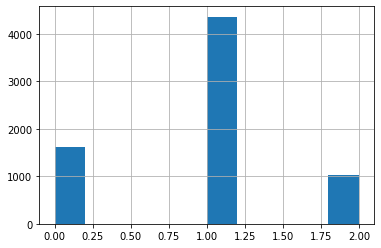

In [16]:
target = train.type
target.hist()

In [17]:
important = ['x_std', 'x_min', 'x_max', 'x_mean', 
            'y_std', 'y_min', 'y_max', 'y_mean', 
            'speed_sin_std', 'speed_sin_max', 'speed_sin_mean', 
            'speed_cos_std', 'speed_cos_max', 'speed_cos_mean',
            'speed_std', 'speed_max', 'speed_mean', 
            'ori_std', 'ori_max', 'ori_mean']

num = ['id', 
       'x_std', 'x_min', 'x_max', 'x_mean', 
       'y_std', 'y_min', 'y_max', 'y_mean', 
       'speed_sin_std', 'speed_sin_min', 'speed_sin_max', 'speed_sin_mean', 
       'speed_cos_std', 'speed_cos_min', 'speed_cos_max', 'speed_cos_mean',
       'speed_std', 'speed_min', 'speed_max', 'speed_mean', 
       'ori_std', 'ori_min', 'ori_max', 'ori_mean']

features = [i for i in num if i in important]
len(features)

20

In [18]:
scaler = StandardScaler()
train[important] = scaler.fit_transform(train[important])
train[important]

,x_std,x_min,x_max,x_mean,y_std,y_min,y_max,y_mean,speed_sin_std,speed_sin_max,speed_sin_mean,speed_cos_std,speed_cos_max,speed_cos_mean,speed_std,speed_max,speed_mean,ori_std,ori_max,ori_mean
0,-0.561751,-0.481411,-0.583659,-0.589869,-0.733104,-0.451055,-0.635067,-0.557333,-0.465947,0.575714,0.489416,-1.374942,-1.135842,-0.132880,-0.493257,-0.069170,-1.105644,-2.971593,-3.894416,-2.174746
1,-0.074971,-0.737770,-0.764905,-0.693781,0.547405,-0.774836,-0.704157,-0.702666,0.153581,-0.407276,-0.243683,0.257997,-0.695451,-0.728231,0.581405,0.092406,-0.148014,-0.397695,-0.166976,-1.178604
2,-0.766067,-0.242729,-0.469796,-0.352696,-0.774045,-0.179835,-0.392333,-0.305347,0.991019,8.387629,0.543785,-0.001446,3.580308,0.361676,1.569120,6.075185,-0.870736,0.762649,0.265191,0.120273
3,-0.034344,-3.792945,-3.742437,-3.869174,-0.202379,-2.612089,-2.649613,-2.666767,0.443121,0.488293,0.156091,-0.011480,0.645021,0.069020,0.695528,0.035555,-0.245478,0.713557,0.121135,0.077329
4,-0.521887,2.983762,2.774408,2.922148,-0.179424,3.378767,3.243342,3.374298,0.131911,0.505638,-0.144988,0.268948,0.621621,0.029078,0.664260,0.035555,-0.287669,0.690527,0.247184,0.423932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0.954782,-0.051338,0.078406,0.048052,0.885207,-0.350640,-0.170606,-0.248711,0.442434,0.591762,1.213694,1.455428,-0.221410,-0.599728,0.964440,0.035555,0.906308,0.822867,0.265191,0.588547
6996,-0.226792,0.686989,0.667973,0.692415,-0.023549,0.763154,0.769158,0.760091,0.107118,0.186597,0.545167,0.806734,0.074428,-0.189717,-0.463305,-0.149957,0.864612,0.122281,0.229177,0.702050
6997,-0.007499,-3.792534,-3.743690,-3.865215,-0.181948,-2.611080,-2.649613,-2.669614,0.560050,0.487543,0.117786,-0.245987,0.290478,0.155278,0.637974,0.035555,-0.224255,0.579324,0.157149,0.395363
6998,-0.416964,0.436643,0.277411,0.356727,0.460642,0.412054,0.493816,0.499432,-0.274385,0.458726,0.096619,0.523549,0.579499,-0.737121,0.207946,0.004138,0.102791,0.296266,0.265191,0.393043


In [19]:
import matplotlib.pyplot as plt

def cm_plot(original_label, predict_label, pic=None):
    cm = confusion_matrix(original_label, predict_label)   # 由原标签和预测标签生成混淆矩阵
    plt.figure()
    plt.matshow(cm, cmap=plt.cm.Blues)     # 画混淆矩阵，配色风格使用cm.Blues
    plt.colorbar()    # 颜色标签
    for x in range(len(cm)):
        for y in range(len(cm)):
            plt.annotate(cm[x, y], xy=(x, y), horizontalalignment='center', verticalalignment='center')
    plt.xlabel('True label')  # 坐标轴标签
    plt.ylabel('Predicted label')  # 坐标轴标签
    plt.title('confusion matrix')
    if pic is not None:
        plt.savefig(str(pic) + '.jpg')
    plt.show()

In [20]:
def F1_score(y_true, y_pred):
    C=confusion_matrix(y_true, y_pred)
    
    TP_0 = C[0][0]
    FN_0 = C[0][1] + C[0][2]
    FP_0 = C[1][0] + C[2][0]
    TN_0 = sum(sum(C)) - TP_0 - FN_0 - FP_0
    precision_0 = TP_0/(TP_0 + FP_0)
    recall_0 = TP_0/(TP_0 + FN_0)
    F1_0 = 2 * precision_0 * recall_0/(precision_0 + recall_0)
    
    TP_1 = C[1][1]
    FN_1 = C[1][0] + C[1][2]
    FP_1 = C[0][1] + C[2][1]
    TN_1 = sum(sum(C)) - TP_1 - FN_1 - FP_1
    precision_1 = TP_1/(TP_1 + FP_1)
    recall_1 = TP_1/(TP_1 + FN_1)
    F1_1 = 2 * precision_1 * recall_1/(precision_1 + recall_1)
    
    TP_2 = C[2][2]
    FN_2 = C[2][0] + C[2][1]
    FP_2 = C[0][2] + C[1][2]
    TN_2 = sum(sum(C)) - TP_2 - FN_2 - FP_2
    precision_2 = TP_2/(TP_2 + FP_2)
    recall_2 = TP_2/(TP_2 + FN_2)
    F1_2 = 2 * precision_2 * recall_2/(precision_2 + recall_2)
    return F1_0, F1_1, F1_2

In [24]:
!pip install keras

In [27]:
import keras.utils

In [28]:
help(keras.utils)

Help on package keras.utils in keras:

NAME
    keras.utils

PACKAGE CONTENTS
    all_utils
    control_flow_util
    conv_utils
    data_utils
    dataset_creator
    generic_utils
    io_utils
    kernelized_utils
    kpl_test_utils
    layer_utils
    losses_utils
    metrics_utils
    mode_keys
    multi_gpu_utils
    np_utils
    object_identity
    tf_contextlib
    tf_inspect
    tf_utils
    traceback_utils
    version_utils
    vis_utils

FILE
    /usr/local/lib/python3.7/dist-packages/keras/utils/__init__.py




In [31]:
from tensorflow.keras.utils import to_categorical
target = to_categorical(target)

In [32]:
target

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [33]:
def NN_model():
  init = keras.initializers.glorot_uniform(seed=1)
  model = keras.models.Sequential()
  model.add(Dense(units=32, input_dim=len(important), kernel_initializer=init, activation='relu'))
  model.add(Dense(units=64, kernel_initializer=init, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units=32, kernel_initializer=init, activation='relu'))
  model.add(Dense(units=16, kernel_initializer=init, activation='relu'))
  model.add(Dense(units=8, kernel_initializer=init, activation='relu'))
  model.add(Dense(units=3, kernel_initializer=init, activation='softmax'))

  return model

In [35]:
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2021)

In [42]:
import keras 


b_size = 2
max_epochs = 100
oof_pred = np.zeros((len(train), ))
models = []
for fold, (trn_idx, val_idx) in enumerate(kf.split(train[important], train.type)):
    print('fold:', fold)
    X_train, y_train = train[important].loc[trn_idx], target[trn_idx]
    X_val, y_val = train[important].loc[val_idx], target[val_idx]
    
    model = NN_model()
    simple_adam = tensorflow.optimizers.Adam()
    model.compile(loss='categorical_crossentropy', optimizer=simple_adam, metrics=['accuracy'])
    es = EarlyStopping(monitor='val_score', patience=10, verbose=1, mode='max', restore_best_weights=True,)
    es.set_model(model)
    metric = Metric(model, [es], [(X_train, y_train), (X_val, y_val)])
    model.fit(X_train, y_train, batch_size=b_size, epochs=max_epochs, 
              validation_data = [X_val, y_val],
              callbacks=[metric], shuffle=True, verbose=1)
    y_pred3 = model.predict(X_val)
    y_pred = np.zeros((len(y_pred3), ))
    models.append(model)
    for i in range(len(y_pred3)):
        y_pred[i] = list(y_pred3[i]).index(max(y_pred3[i]))
        
    oof_pred[val_idx] = y_pred
    F1_0_val, F1_1_val, F1_2_val = F1_score(train.type.loc[val_idx], y_pred)
    score_ = (F1_0_val + F1_1_val + F1_2_val)/3
    print()
    print('F1_0_val is:{}, F1_1_val is:{}, F1_2_val is:{}, total score is : {}'.format(F1_0_val, F1_1_val, F1_2_val, score_))
    print()

F1_0, F1_1, F1_2 = F1_score(train.type, oof_pred)
score_ = (F1_0 + F1_1 + F1_2)/3
print()
print('F1_0_val is:{}, F1_1_val is:{}, F1_2_val is:{}, total score is : {}'.format(F1_0, F1_1, F1_2, score_))
f1_score(train.type, oof_pred, average='macro')

fold: 0
Epoch 1/100
2800/2800 [==============================] - 14s 4ms/step - loss: 0.6801 - accuracy: 0.7129 - val_loss: 0.6146 - val_accuracy: 0.7457 - trn_score: 0.5723 - val_score: 0.5702
Epoch 2/100
2800/2800 [==============================] - 13s 5ms/step - loss: 0.5940 - accuracy: 0.7518 - val_loss: 0.5879 - val_accuracy: 0.7393 - trn_score: 0.7032 - val_score: 0.6719
Epoch 3/100
2800/2800 [==============================] - 13s 5ms/step - loss: 0.5602 - accuracy: 0.7620 - val_loss: 0.5733 - val_accuracy: 0.7414 - trn_score: 0.7200 - val_score: 0.6838
Epoch 4/100
2800/2800 [==============================] - 12s 4ms/step - loss: 0.5446 - accuracy: 0.7652 - val_loss: 0.5664 - val_accuracy: 0.7471 - trn_score: 0.7234 - val_score: 0.6878
Epoch 5/100
2800/2800 [==============================] - 13s 5ms/step - loss: 0.5312 - accuracy: 0.7736 - val_loss: 0.5631 - val_accuracy: 0.7479 - trn_score: 0.7207 - val_score: 0.6855
Epoch 6/100
2800/2800 [==============================] - 13s 5

0.7374511220525378

In [46]:
%cd COLAB

/gdrive/My Drive/COLAB


In [47]:
!ls

hy_round1_train_20200102  npy	    test.feather       train.feather
new.ipynb		  RF.ipynb  Tianchi_CNN.ipynb


In [48]:
test = pd.read_feather('test.feather')

In [51]:
test

,渔船ID,x,y,速度,方向,time
0,7000,7.118845e+06,5.918277e+06,0.11,0,1103 11:54:32
1,7000,7.118940e+06,5.918285e+06,0.32,346,1103 11:44:32
2,7000,7.118948e+06,5.918174e+06,0.11,0,1103 11:34:43
3,7000,7.118948e+06,5.918174e+06,0.11,71,1103 11:14:30
4,7000,7.118948e+06,5.918174e+06,0.11,30,1103 11:04:46
...,...,...,...,...,...,...
782373,8999,6.283750e+06,5.284013e+06,0.00,0,1028 00:59:02
782374,8999,6.283750e+06,5.284013e+06,0.00,0,1028 00:49:26
782375,8999,6.283750e+06,5.284013e+06,0.05,0,1028 00:29:04
782376,8999,6.283750e+06,5.284013e+06,0.05,0,1028 00:19:04


In [52]:
test.columns = ['id', 'x', 'y', 'speed', 'ori', 'time']
test.head()

,id,x,y,speed,ori,time
0,7000,7.118845e+06,5.918277e+06,0.11,0,1103 11:54:32
1,7000,7.118940e+06,5.918285e+06,0.32,346,1103 11:44:32
2,7000,7.118948e+06,5.918174e+06,0.11,0,1103 11:34:43
3,7000,7.118948e+06,5.918174e+06,0.11,71,1103 11:14:30
4,7000,7.118948e+06,5.918174e+06,0.11,30,1103 11:04:46


In [53]:
test = feature_engineer(test, test=True)

In [54]:
test[important] = scaler.fit_transform(test[important])
test[important]

,x_std,x_min,x_max,x_mean,y_std,y_min,y_max,y_mean,speed_sin_std,speed_sin_max,speed_sin_mean,speed_cos_std,speed_cos_max,speed_cos_mean,speed_std,speed_max,speed_mean,ori_std,ori_max,ori_mean
0,-0.262833,3.069990,3.035617,3.101512,-0.406656,2.393115,2.453454,2.432599,0.363191,0.469540,0.520874,0.538807,0.455983,-0.638705,1.042360,0.021187,-0.144552,0.507427,0.254471,0.379963
1,-0.404578,-0.098783,-0.211853,-0.138093,0.066743,-0.237080,-0.217537,-0.234868,0.466428,0.518821,-0.292704,1.105678,0.822715,0.113178,0.467624,0.021187,0.860456,0.077351,0.180373,0.624419
2,0.944927,1.199837,1.632259,1.530079,1.641883,0.528292,0.983135,0.785946,0.645973,0.212303,1.821421,0.553906,0.507174,2.347646,0.719707,0.021187,0.797401,0.425439,0.235947,0.820567
3,-0.129142,-0.343044,-0.397233,-0.436262,-0.430396,-0.244431,-0.349826,-0.272895,0.446298,0.575161,-0.041552,-0.108925,0.110184,0.000014,0.836987,0.021187,-0.515798,0.661055,0.254471,0.078360
4,-0.072288,0.393188,0.360064,0.311796,0.001638,0.376797,0.388380,0.466091,0.296491,0.661817,0.571083,0.306650,0.284893,-0.275893,0.868187,0.021187,-0.274008,0.544657,0.161849,0.110225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.272909,0.448762,0.813073,0.434242,-0.564160,0.631898,0.476017,0.536370,1.310504,-0.028098,-2.264725,-0.229295,0.822326,-0.305646,1.530288,0.021187,0.095520,0.388622,0.180373,0.821723
1996,-0.396299,0.525873,0.411600,0.493597,0.624527,0.386501,0.529850,0.411957,0.184931,0.668171,-0.182833,1.381210,0.783881,0.274104,0.353567,0.021187,0.969127,0.187911,0.235947,0.889243
1997,-0.736703,0.556438,0.306443,0.446030,-0.770590,0.858814,0.642283,0.758270,-1.602782,-1.452558,0.012218,-1.608907,-1.637190,0.040152,-1.760166,-1.513177,-1.272015,-2.916314,-0.060445,-2.286806
1998,-0.145311,-0.130097,-0.178028,-0.150768,1.458013,-0.457088,-0.218293,-0.273590,-0.063972,0.281910,-0.285366,0.560433,-0.433942,-1.623616,0.572493,0.021187,0.098524,0.254146,0.217422,0.245763


In [73]:
y_preds = []
for model in models:
    y_preds.append(model.predict(train[important]))
y = np.mean(y_preds, axis=0)

In [74]:
y_ = np.zeros([len(y), 1])

for i in range(len(y)):
    y_[i] = list(y[i]).index(max(y[i]))
y_, len(y)

(array([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]), 7000)

<Figure size 432x288 with 0 Axes>

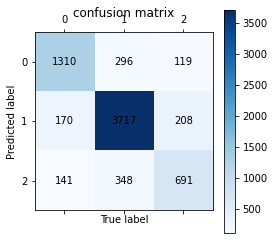

In [75]:
cm_plot(original_label=train['type'], predict_label=y_, pic=None)

In [86]:
clear(str)

In [90]:
from tensorflow.keras.utils import plot_model
#plot_model(models[0], to_file="lenet.png", show_shapes=True)
i = 1
for model in models:
  s = str(i)+'.png'
  i += 1
  plot_model(model,to_file=s,show_shapes=True)